<a href="https://colab.research.google.com/github/annisajumalia/SintiaLa-biran/blob/main/Jenis_sabun_SintiaLa'biran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download -d sintialabiran28/jenis-sabun
!mkdir jenis-sabun
!unzip /content/jenis-sabun.zip -d /content/jenis-sabun

  0% 0.00/2.84M [00:00<?, ?B/s]
100% 2.84M/2.84M [00:00<00:00, 131MB/s]
Archive:  /content/jenis-sabun.zip
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (1).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (10).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (100).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (11).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (12).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (13).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (14).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (15).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (16).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabun batang (17).jpg  
  inflating: /content/jenis-sabun/jenis sabun/sabun batang/sabu

In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [6]:
dataset_path = Path(r'/content/jenis-sabun')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))
     

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/jenis-sabun/jenis sabun/sabun cair/sa...,sabun cair
1,/content/jenis-sabun/jenis sabun/sabun cair/sa...,sabun cair
2,/content/jenis-sabun/jenis sabun/sabun cair/sa...,sabun cair
3,/content/jenis-sabun/jenis sabun/sabun cair/sa...,sabun cair
4,/content/jenis-sabun/jenis sabun/sabun cair/sa...,sabun cair


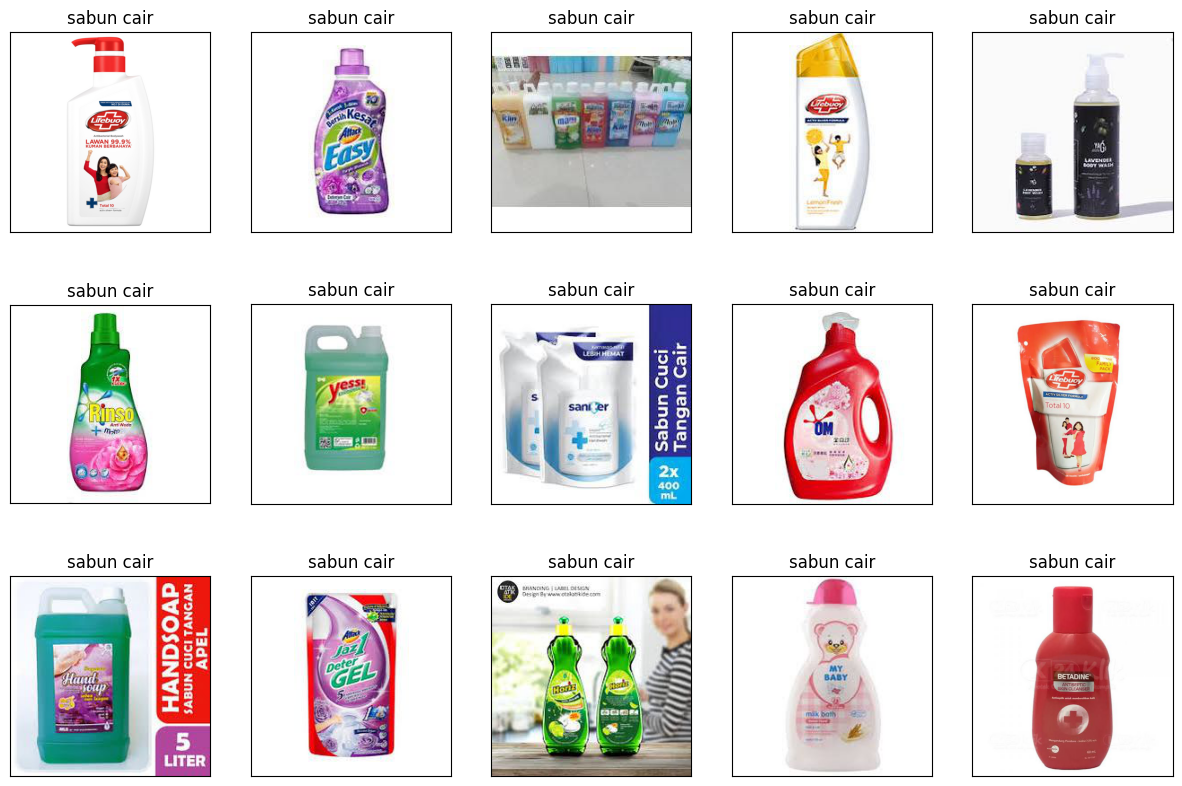

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [9]:
df.label.value_counts()

sabun cair      100
sabun batang    100
sabun bubuk     100
Name: label, dtype: int64

In [10]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

sabun cair      100
sabun batang    100
sabun bubuk     100
Name: label, dtype: int64

In [11]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)
     

In [12]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [13]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)
     

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [14]:
input_shape = (200, 200, 3)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [16]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)
     

Epoch 1/100
6/6 [==============================] - 29s 5s/step - loss: 1.1137 - accuracy: 0.3333 - val_loss: 1.0900 - val_accuracy: 0.3810
Epoch 2/100
6/6 [==============================] - 27s 4s/step - loss: 1.0962 - accuracy: 0.3512 - val_loss: 1.0918 - val_accuracy: 0.3810
Epoch 3/100
6/6 [==============================] - 26s 4s/step - loss: 1.1141 - accuracy: 0.3750 - val_loss: 1.0882 - val_accuracy: 0.3810
Epoch 4/100
6/6 [==============================] - 26s 4s/step - loss: 1.1007 - accuracy: 0.3452 - val_loss: 1.0870 - val_accuracy: 0.3810
Epoch 5/100
6/6 [==============================] - 25s 4s/step - loss: 1.1028 - accuracy: 0.3571 - val_loss: 1.0749 - val_accuracy: 0.3810
Epoch 6/100
6/6 [==============================] - 27s 4s/step - loss: 1.0822 - accuracy: 0.3571 - val_loss: 1.0579 - val_accuracy: 0.3810
Epoch 7/100
6/6 [==============================] - 28s 5s/step - loss: 1.0864 - accuracy: 0.3571 - val_loss: 1.0361 - val_accuracy: 0.3810


In [17]:
model.save('model-1.h5')

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
     

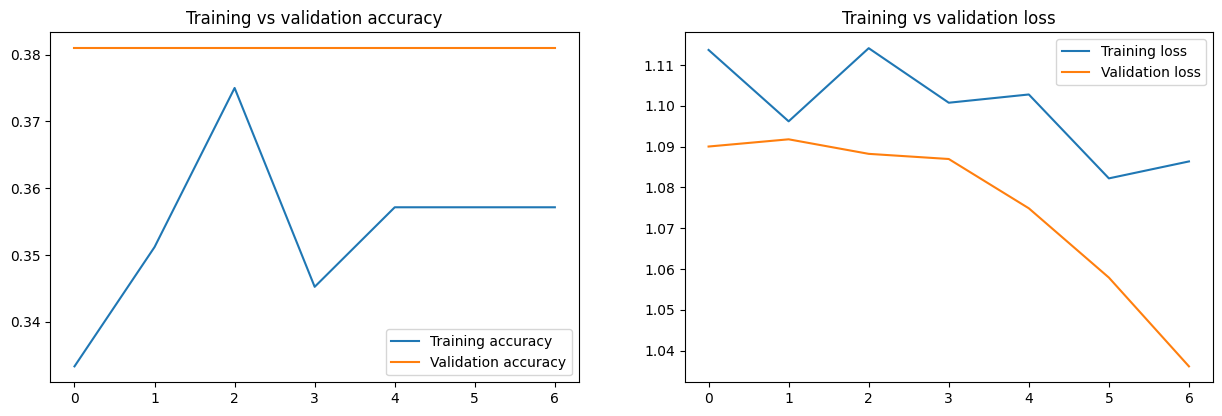

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [20]:
pred = model.predict(test)

3/3 [==============================] - 5s 1s/step


In [21]:
pred = np.argmax(pred, axis=1)
     

In [22]:
labels = train.class_indices

In [23]:
labels

{'sabun batang': 0, 'sabun bubuk': 1, 'sabun cair': 2}

In [24]:
labels = dict((v,k) for k, v in labels.items())

In [25]:
labels

{0: 'sabun batang', 1: 'sabun bubuk', 2: 'sabun cair'}

In [26]:
y_pred = [labels[k] for k in pred]

In [27]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

sabun batang       0.00      0.00      0.00        33
 sabun bubuk       0.27      1.00      0.42        24
  sabun cair       0.00      0.00      0.00        33

    accuracy                           0.27        90
   macro avg       0.09      0.33      0.14        90
weighted avg       0.07      0.27      0.11        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(confusion_matrix(x_test.label, y_pred))

[[ 0 33  0]
 [ 0 24  0]
 [ 0 33  0]]


In [29]:
test_accuracy = model.evaluate(test)[1]


3/3 [==============================] - 4s 980ms/step - loss: 1.1279 - accuracy: 0.2667
